Fetch the images from the Dataset (in `../A2_Data.csv`)

In [1]:
import csv
import os
import requests
import os
import time
from PIL import Image
from io import BytesIO
import string
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stps = stopwords.words("english")

image_dir = '../A2_images'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load the csv
with open('../A2_Data.csv', 'r') as file:
    reader = csv.reader(file)
    data = list(reader)

# remove the header
header = data[0]
data = data[1:]

# schema: id, url, review
bad_ids = set(['3474', '3317', '2088', '2265', '2235', '2912'])

# remove the bad ids
data = [d for d in data if d[0] not in bad_ids]

print(bad_ids, "did not have a valid image (noted while fetching)")

{'3317', '2088', '2235', '2265', '3474', '2912'} did not have a valid image (noted while fetching)


# Q1. Image Feature Extraction [25]
   1. Use basic image pre-processing techniques as altering contrast, resizing, geometrical orientation, random flips, brightness and exposure or any other relevant operation.
   2. Use a pre-trained Convolutional Neural Network Architecture as ResNet, VGG16, Inception-v3, MobileNet ( or any other CNN , preferably pre-trained on ImageNet Dataset), to extract relevant features from the images in the given training Set. Choose only one of the networks for your final pipeline. 
   3. Normalize the extracted features.

In [ ]:
## Data downloading
## One time running ---------------- DO NOT RUN AGAIN ----------------

# create a directory to store the images

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

counter = 1
# download the images
for id_a, urls, labels in data:
    print(counter, "heeh")
    counter += 1
    for i, url in enumerate(eval(urls)):
        # print("Trying to download image", id_a, i, "from", url)
        response = requests.get(url)
        if response.status_code != 200:
            print(f'Failed to download image {id_a}_{i} from {url}')
            continue
        img = Image.open(BytesIO(response.content))
        img_path = os.path.join(image_dir, f'{id_a}_{i}.jpg')
        img.save(img_path)
        # print(f'Image {id_a}_{i} saved to {img_path}')
        time.sleep(0.1) # sleep for 1 second to avoid being blocked by the server

In [3]:
transforms_compositor = transforms.Compose(
    [ 
        transforms.Resize((224, 224)),
        transforms.GaussianBlur(5),
        # rotate the image
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(contrast=0.1, brightness=0.1, saturation=0.1, hue=0.1),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

transforms_compositor_fetch = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [4]:
## Time for part 1.1; preprocessing the images
## NO NEED TO RUN, but can run

# load the images
images = []
bad_ids = set()
for id_a, urls, labels in data:
    for i, url in enumerate(eval(urls)):
        img_path = os.path.join(image_dir, f'{id_a}_{i}.jpg')
        try:
            img = Image.open(img_path)
            img = img.convert('RGB')
        except FileNotFoundError:
            bad_ids.add(id_a)
            continue
        
        images.append(img)

images_emb_in = [transforms_compositor(img) for img in images]
## Will not store this; directly store features


Original image


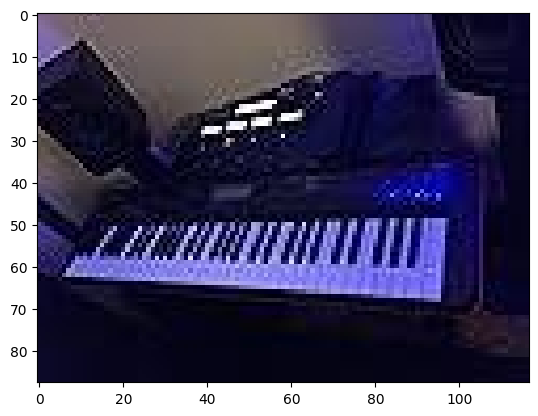

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image being sent for embedding image


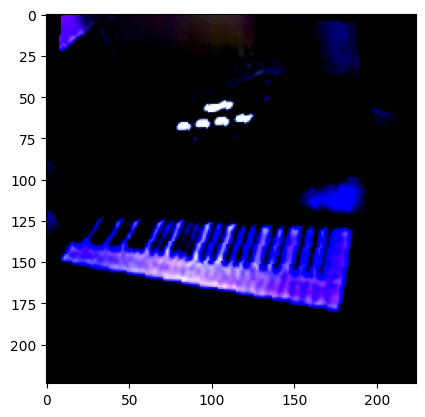

In [5]:
## Visuals (No need to run)

print("Original image")
plt.imshow(images[1116])
plt.show()
print("Image being sent for embedding image")
plt.imshow(images_emb_in[1116].permute(1, 2, 0))
plt.show()

In [6]:
# load the pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# remove the last layer
model = nn.Sequential(*list(model.children())[:-1])
model = model.eval()

In [7]:
## Time for part 1.2; extract the features using ResNet50
## DO NOT RUN ---------------- ONE TIME RUN -------------

# create a dataset
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# create a dataloader
dataset = ImageDataset(images_emb_in)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# extract the features
features = []
for batch in dataloader:
    with torch.no_grad():
        feature = model(batch)
        feature = feature.view(feature.size(0), -1)
        features.append(feature)

# convert the features to a numpy array
features = torch.cat(features, dim=0).numpy()

In [8]:
# save the normalized features
## DO NOT RUN -------------- ONE TIME RUN------------------
np.save('../A2_features_normalized.npy', features)

# Q2. Text Feature Extraction [25]
   1. Implement relevant pre-processing techniques as Lower-Casing, Tokenization, removing punctuations, Stop Word Removal, Stemming and Lemmatization on the given text reviews in the data
   2. Calculate the Term Frequency-Inverse Document Frequency (TF-IDF) scores for the textual reviews.
    Note: Please make sure to save your extracted features and the TF-IDF score using the pickle module so that you can run your code quickly in the demo

In [9]:
def preproc(review:str):
    # lowercase the review
    review = review.lower()

    # tokenize the review using nltk
    tokens = word_tokenize(review)

    # remove the stopwords
    tokens = [token for token in tokens if token not in stps]

    # remove the punctuation
    tokens = [token for token in tokens if token.isalnum()]

    # perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [10]:
# remember to ignore bad_ids
text_features = []

for id_a, urls, review in data:
    if id_a in bad_ids:
        continue

    text_features.append(preproc(review))

# save the text features as pickle
import pickle
with open('../A2_text_features.pkl', 'wb') as file:
    pickle.dump(text_features, file)


[('workspac', 6.901737206656574), ('maximum', 6.901737206656574), ('beati', 6.901737206656574), ('win', 6.901737206656574), ('fortissimo', 6.901737206656574), ('exstra', 6.901737206656574), ('poutch', 6.901737206656574), ('vertic', 6.901737206656574), ('highlight', 6.901737206656574), ('pud', 6.901737206656574)]
4430


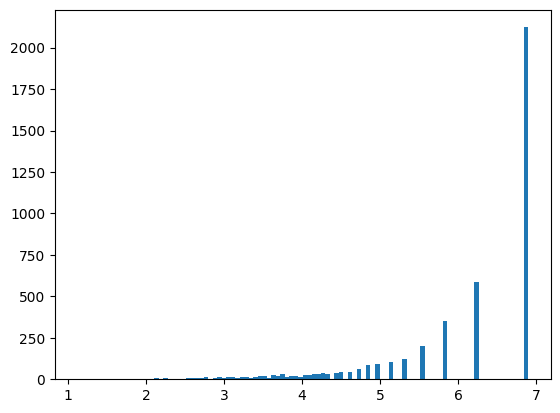

In [22]:
## Time for 2.2; Calculate the TF IDF score for textual review

## first we will calculate IDF of each word
## then chop off the words with low IDF scores and create an embedding vector

## note that IDF is calculated as ln(N/n) where N is the total number of documents and n is the number of documents containing the word
## so be careful of repetitions in single document

## DO NOT RUN ----------------- ONE TIME RUN -------------------

# calculate the IDF
N = len(text_features)
idf = {}
for tokens in text_features:
    for token in set(tokens):
        idf[token] = idf.get(token, 0) + 1

for token in idf:
    idf[token] = np.log(N / idf[token])

# save the idf
# with open('../A2_idf.pkl', 'wb') as file:
#     pickle.dump(idf, file)

# get the top 10 lowest idf
idf = {k: v for k, v in sorted(idf.items(), key=lambda item: item[1], reverse=True)}
print(list(idf.items())[:10])
print(len(idf))

## plot histogram of IDF scores
plt.hist(list(idf.values()), bins=100)
plt.show()

In [23]:
# Cutoff of 4.5 seems good
idf_cutoff = 4.5

# drop the words with low idf
# idf = {k: v for k, v in idf.items() if v > idf_cutoff}
idf_keys = list(idf.keys())

# now create a vector for each review (i.e. the tf-idf vector)
text_features_emb = []
for tokens in text_features:
    vector = np.zeros(len(idf))
    for token in tokens:
        if token in idf:
            vector[idf_keys.index(token)] += 1
    
    # multiply by idf
    vector = vector * np.array([idf[token] for token in idf])

    text_features_emb.append(vector)

# save the text features as pickle
with open('../A2_text_features_emb.pkl', 'wb') as file:
    pickle.dump(text_features_emb, file)

# Q3. Image Retrieval and Text Retrieval [25]
1. For the input (image, review) pair, find the most similar images (preferably your
top three) to your input based on extracted image features/embeddings using a
similarity measure (cosine similarity) and a suitable data-structure.
2. For the input (image, review) pair, find the most similar reviews (preferably your
top three) to your input review based on TF-IDF scores using a similarity
measure (Cosine Similarity)
3. Save your results using Python’s pickle module to save and load your results.

In [24]:
with open('../A2_text_features_emb.pkl', 'rb') as file:
    text_features_emb = pickle.load(file)

features = np.load('../A2_features_normalized.npy')

Top 3 similar product lookup tool
=======================Top 3 similar products=======================
=======================USING TEXTUAL REVIEW==========================
[INFO] Similarity score:  0.7716462933109883
2511 https://images-na.ssl-images-amazon.com/images/I/713koU-p-sL._SY88.jpg Rock solid, and everything you need to hang your instrument.  Someone's review stated that they were ugly.  Seriously?  I used to buy these for about $25 a piece, and they all look the same.  These get the job done at about 1/3 of the price of most music shops, and if I can trust my Gibson and Martin guitars on them, they are solid.
639 1640


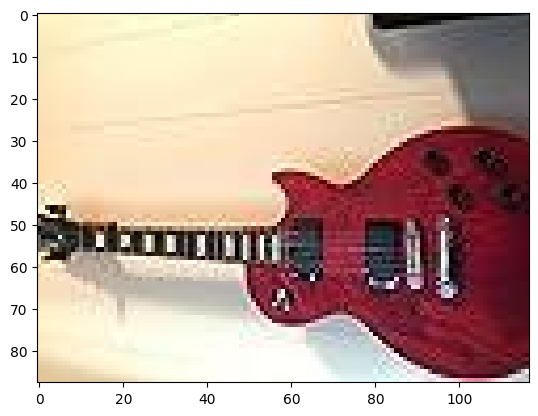

[INFO] Similarity score:  0.2311945861716583
325 https://images-na.ssl-images-amazon.com/images/I/81hhee6cBhL._SY88.jpg Great nylon strings, just as expected. They worked just fine on my daughter's mini classical guitar. They are as good quality wise as much more expensive strings I've purchased in the past. They are much softer to the touch and easier for her to learn on than my steel strings on my acoustic guitar. They came labeled with both the note name and the string number, which made putting them on easy and quick.
15 1640


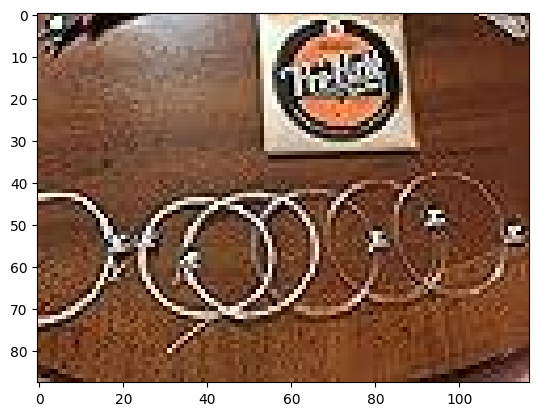

[INFO] Similarity score:  0.23005613525758808
2624 https://images-na.ssl-images-amazon.com/images/I/61AcfA-SB-L._SY88.jpg It's definitely tiny. They weren't kidding about that. That being said, the screen is 1"X1", but pretty bright and easy to read. The colors are rich, which helps. I play 6, 7, and 8 string guitars and was able to tune all 3 with no problems. Quick detection, and accurate. Even the F# on the 8 string was picked up almost instantly.

It may be a drawback for some, but there's no option for a 9V battery. Pick up a Donner 9v plug w/ that comes with a pig tail that has 5 9v plugs on it.

He's a tiny little feller, but big things come in small packages.
206 1640


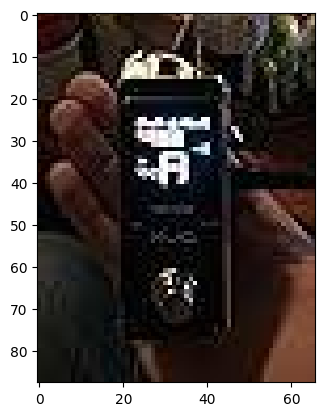

=======================Top 3 similar products=======================
=======================USING IMAGE FEATURES==========================
[INFO] Similarity score:  [0.87094206]
2182 https://images-na.ssl-images-amazon.com/images/I/81poVqg6ajL._SY88.jpg Small but powerful enough. It is well made, pretty basic for a speaker.  I would probably buy another one.

This was probably made in China but it does say designed and tuned in USA.
1075 1640


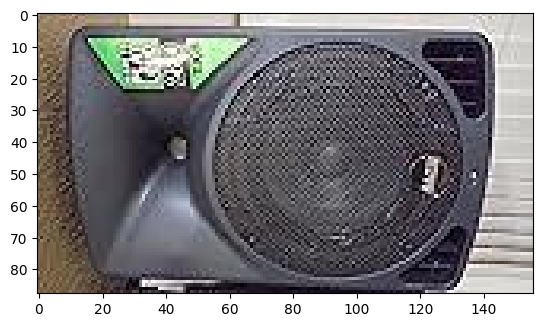

[INFO] Similarity score:  [0.59727854]
799 https://images-na.ssl-images-amazon.com/images/I/81WKziUbhVL._SY88.jpg I bought a pair of these just over a year ago, at first they worked just fine then I started getting static when adjusting the Volume control to the point where the Main speaker was not playing but the other one was. Having bought then outside of the US it was very difficult to get the warranty honored so I decided to fix them myself as I am a technician. What I discovered was the volume controller which is also the Power switch was defective, and I could not get a replacement. so what I did was replace the volume control with another one and and added a power switch. Now it works like a charm.
1443 1640


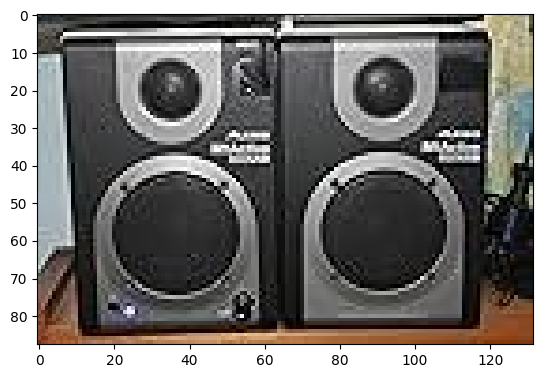

[INFO] Similarity score:  [0.5604534]
2727 https://images-na.ssl-images-amazon.com/images/I/41Sw61W74tL._SY88.jpg Never lose your pick again. This is an essential item in your repertoire of gadgets for guitar players. I tried this almost on every surface I could possibly stick it to, and every time it worked great (except on dry wall...). Needless to say, this is designed for guitars, so any guitar you have, you can stick it to. No adhesive, no tape, no mess. Just press, and there you have it. Check the pics. I love Ernie Ball products, and this is another winner. Patent pending, made in China.
1604 1640


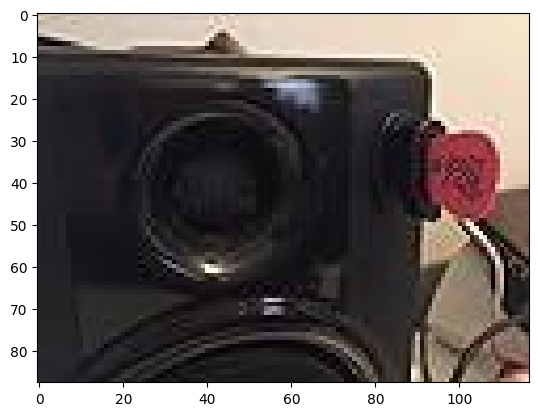

=======================Top 3 similar products=======================
=======================USING COMBINED FEATURES=======================
[INFO] Similarity score:  [0.60965943]
2182 https://images-na.ssl-images-amazon.com/images/I/81poVqg6ajL._SY88.jpg Small but powerful enough. It is well made, pretty basic for a speaker.  I would probably buy another one.

This was probably made in China but it does say designed and tuned in USA.
1075 1640


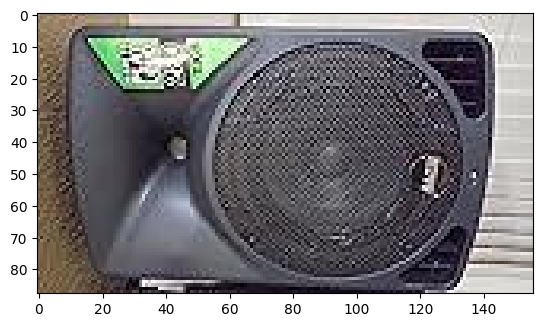

[INFO] Similarity score:  [0.41809496]
799 https://images-na.ssl-images-amazon.com/images/I/81WKziUbhVL._SY88.jpg I bought a pair of these just over a year ago, at first they worked just fine then I started getting static when adjusting the Volume control to the point where the Main speaker was not playing but the other one was. Having bought then outside of the US it was very difficult to get the warranty honored so I decided to fix them myself as I am a technician. What I discovered was the volume controller which is also the Power switch was defective, and I could not get a replacement. so what I did was replace the volume control with another one and and added a power switch. Now it works like a charm.
1443 1640


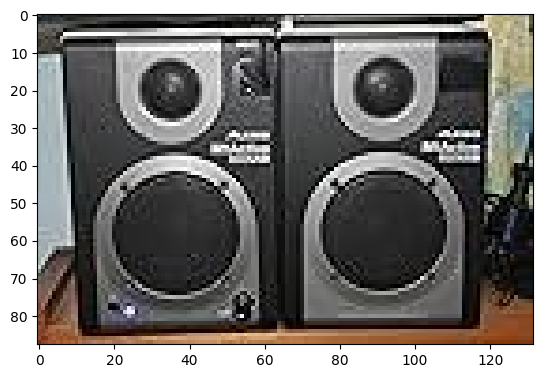

[INFO] Similarity score:  [0.39231738]
2727 https://images-na.ssl-images-amazon.com/images/I/41Sw61W74tL._SY88.jpg Never lose your pick again. This is an essential item in your repertoire of gadgets for guitar players. I tried this almost on every surface I could possibly stick it to, and every time it worked great (except on dry wall...). Needless to say, this is designed for guitars, so any guitar you have, you can stick it to. No adhesive, no tape, no mess. Just press, and there you have it. Check the pics. I love Ernie Ball products, and this is another winner. Patent pending, made in China.
1604 1640


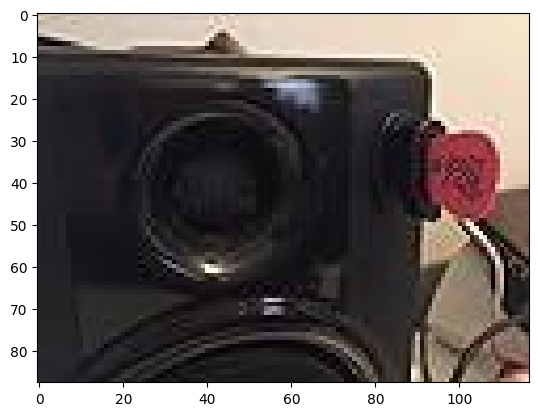

In [28]:
print("Top 3 similar product lookup tool")
# part a and b implemented here
if True:
    input_image = input("Enter location of image: ")
    input_review = input("Enter review: ")

    # get the text features of the input review
    input_review = preproc(input_review)
    input_review_emb = np.zeros(len(idf))
    for token in input_review:
        if token in idf:
            input_review_emb[idf_keys.index(token)] += 1
    input_review_emb = input_review_emb * np.array([idf[token] for token in idf])

    # print("[DEBUG] Input review embedding", input_review_emb)

    # calculate the cosine similarity
    cosine_similarities_txt = []
    for i, f in enumerate(text_features_emb):
        if np.linalg.norm(f) < 0.000000000001: #case of empty review ignored
            cosine_similarities_txt.append((i, -1))
            continue
        cosine_similarity = np.dot(f, input_review_emb) / (np.linalg.norm(f) * np.linalg.norm(input_review_emb))
        cosine_similarities_txt.append((i, cosine_similarity))


    # sort the cosine similarities
    cosine_similarities_txt = sorted(cosine_similarities_txt, key=lambda x: x[1], reverse=True)

    # print the top 3 similar products
    print("=======================Top 3 similar products=======================")
    print("=====================================================================")
    print("=======================USING TEXTUAL REVIEW==========================")
    for i, similarity in cosine_similarities_txt[:3]:
        print("[INFO] Similarity score: ", similarity)
        # unflatten i to fit data index
        # -----------
        q=0
        for id_a, urls, review in data:
            for j, url in enumerate(eval(urls)):
                if i == 0:
                    print(id_a, url, review)
                    i -= 1
                    break
                elif i<0:
                    continue
                else:
                    i -= 1
                    q+=1
        # -----------
        # display the processed images
        print(q, len(images))
        # images[q].show()  
        # convert back from tensor to image
        plt.imshow((images[q]))
        plt.show()
    

    # load the image
    # get from the internet
    response = requests.get(input_image)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB')
    # crop to 224x224
    img = transforms_compositor_fetch(img).unsqueeze(0)

    # extract the features
    with torch.no_grad():
        feature = model(img)
        feature = feature.view(feature.size(0), -1)
        feature = feature.numpy()

    # calculate the cosine similarity
    cosine_similarities = []
    for i, f in enumerate(features):
        cosine_similarity = np.dot(f, feature.T) / (np.linalg.norm(f) * np.linalg.norm(feature))
        cosine_similarities.append((i, cosine_similarity))

    # sort the cosine similarities
    cosine_similarities_img = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)

    # print the top 3 similar products
    print("=======================Top 3 similar products=======================")
    print("=====================================================================")
    print("=======================USING IMAGE FEATURES==========================")
    for i, similarity in cosine_similarities_img[:3]:
        print("[INFO] Similarity score: ", similarity)
        # unflatten i to fit data index
        # -----------
        q=0
        for id_a, urls, review in data:
            for j, url in enumerate(eval(urls)):
                if i == 0:
                    print(id_a, url, review)
                    i -= 1
                    break
                elif i<0:
                    continue
                else:
                    i -= 1
                    q+=1
        # -----------
        # display the processed images
        print(q, len(images))
        # images[q].show()  
        # convert back from tensor to image
        plt.imshow((images[q]))
        plt.show()

    # Now finally, we will combine the two scores and print the top 3 similar products
    # we will use a weighted sum of the two scores
    # the weights are arbitrary and can be tuned
    w_img = 0.7
    w_txt = 0.3
    combined_scores = {}
    for i, similarity in cosine_similarities_img:
        combined_scores[i] = w_img * similarity

    for i, similarity in cosine_similarities_txt:
        if i in combined_scores:
            combined_scores[i] += w_txt * similarity
        else:
            combined_scores[i] = w_txt * similarity

    # sort the combined scores
    combined_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    # print the top 3 similar products
    print("=======================Top 3 similar products=======================")
    print("=====================================================================")
    print("=======================USING COMBINED FEATURES=======================")

    for i, similarity in combined_scores[:3]:
        print("[INFO] Similarity score: ", similarity)
        # unflatten i to fit data index
        # -----------
        q=0
        for id_a, urls, review in data:
            for j, url in enumerate(eval(urls)):
                if i == 0:
                    print(id_a, url, review)
                    i -= 1
                    break
                elif i<0:
                    continue
                else:
                    i -= 1
                    q+=1
        # -----------
        # display the processed images
        print(q, len(images))
        # images[q].show()  
        # convert back from tensor to image
        plt.imshow((images[q]))
        plt.show()

    print("=====================================================================")
        

    